In [249]:
!pip install pandas numpy matplotlib seaborn scikit-learn imbalanced-learn xgboost lightgbm shap lime gradio openpyxl

**Importing** **libraries**

In [276]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
import shap
import joblib
import lime
import lime.lime_tabular
import gradio as gr
from openpyxl import Workbook
from openpyxl.utils.dataframe import dataframe_to_rows

**Load** **dataset**

In [223]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv')
external_data = pd.read_csv('external_data.csv')

**Merging Datasets**

In [224]:
# Merge datasets
if 'Residence_type' in external_data.columns:
    df = df.merge(external_data, on='Residence_type', how='left')
    print("External data merged successfully")
else:
    print("External data doesn't have a matching column - skipping merge")

External data merged successfully


In [225]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,pollution_index,health_accessibility
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1,78,0.90
1,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1,75,0.85
2,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1,72,0.88
3,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1,52,0.60
4,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1,50,0.65


In [200]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12816 entries, 0 to 12815
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    12816 non-null  int64  
 1   gender                12816 non-null  object 
 2   age                   12816 non-null  float64
 3   hypertension          12816 non-null  int64  
 4   heart_disease         12816 non-null  int64  
 5   ever_married          12816 non-null  object 
 6   work_type             12816 non-null  object 
 7   Residence_type        12816 non-null  object 
 8   avg_glucose_level     12816 non-null  float64
 9   bmi                   12308 non-null  float64
 10  smoking_status        12816 non-null  object 
 11  stroke                12816 non-null  int64  
 12  pollution_index       12816 non-null  int64  
 13  health_accessibility  12816 non-null  float64
dtypes: float64(4), int64(5), object(5)
memory usage: 1.4+ MB


In [188]:
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,pollution_index_ext_x,health_accessibility_ext_x,pollution_index_ext_y,health_accessibility_ext_y
count,33420.000000,33420.000000,33420.000000,33420.000000,33420.000000,33420.000000,33420.000000,33420.000000,33420.000000,33420.000000,33420.000000
mean,36506.482256,43.349156,0.096559,0.054279,106.062088,28.857229,0.050000,67.778456,0.800941,67.778456,0.800941
std,21257.171170,22.666771,0.295361,0.226571,45.305727,7.673583,0.217948,11.210068,0.117503,11.210068,0.117503
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000,50.000000,0.600000,50.000000,0.600000
25%,17492.000000,25.000000,0.000000,0.000000,77.160000,23.800000,0.000000,52.000000,0.650000,52.000000,0.650000
50%,36803.000000,45.000000,0.000000,0.000000,91.440000,28.000000,0.000000,72.000000,0.850000,72.000000,0.850000
75%,54807.000000,61.000000,0.000000,0.000000,113.950000,32.900000,0.000000,75.000000,0.880000,75.000000,0.880000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000,78.000000,0.900000,78.000000,0.900000


**Check for missing values**

In [189]:
print(df.isnull().sum())

id                            0
gender                        0
age                           0
hypertension                  0
heart_disease                 0
ever_married                  0
work_type                     0
Residence_type                0
avg_glucose_level             0
bmi                           0
smoking_status                0
stroke                        0
pollution_index_ext_x         0
health_accessibility_ext_x    0
pollution_index_ext_y         0
health_accessibility_ext_y    0
dtype: int64


**Fill missing BMI values with median**

In [227]:
df['bmi'].fillna(df['bmi'].median(), inplace=True)
if 'pollution_index' in df.columns:
    df['pollution_index'].fillna(df['pollution_index'].median(), inplace=True)
if 'health_accessibility' in df.columns:
    df['health_accessibility'].fillna(df['health_accessibility'].median(), inplace=True)

<ipython-input-227-9ab18790ec7d>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['bmi'].fillna(df['bmi'].median(), inplace=True)
<ipython-input-227-9ab18790ec7d>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try 

In [228]:
print(df.isnull().sum())

id                      0
gender                  0
age                     0
hypertension            0
heart_disease           0
ever_married            0
work_type               0
Residence_type          0
avg_glucose_level       0
bmi                     0
smoking_status          0
stroke                  0
pollution_index         0
health_accessibility    0
dtype: int64


**Define global mapping variables**

In [257]:
gender_map = {"Female": 0, "Male": 1, "Other": 2}
married_map = {"No": 0, "Yes": 1}
work_map = {"Children": 0, "Govt_job": 1, "Never_worked": 2, "Private": 3, "Self-employed": 4}
residence_map = {"Rural": 0, "Urban": 1}
smoking_map = {"Unknown": 0, "Formerly smoked": 1, "Never smoked": 2, "Smokes": 3}

**Creating Age Groups for Analysis**

In [229]:
df['age_group'] = pd.cut(df['age'], bins=[0, 20, 40, 60, 80, 100], labels=['0-20', '21-40', '41-60', '61-80', '81-100'])

**Data Visualization**

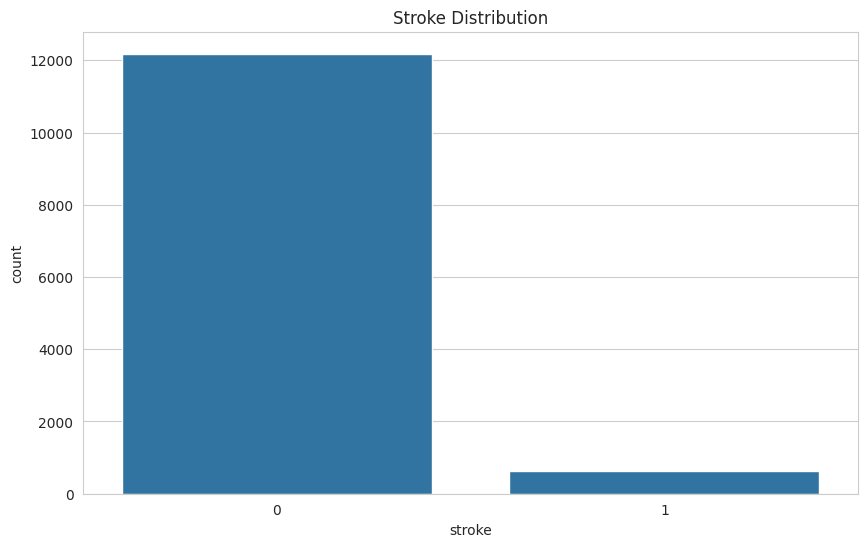

In [231]:
plt.figure(figsize=(10, 6))
sns.set_style('whitegrid')
sns.countplot(x='stroke', data=df)
plt.title('Stroke Distribution')
plt.savefig('stroke_distribution.png')
plt.show()

**Plot age distribution by stroke**

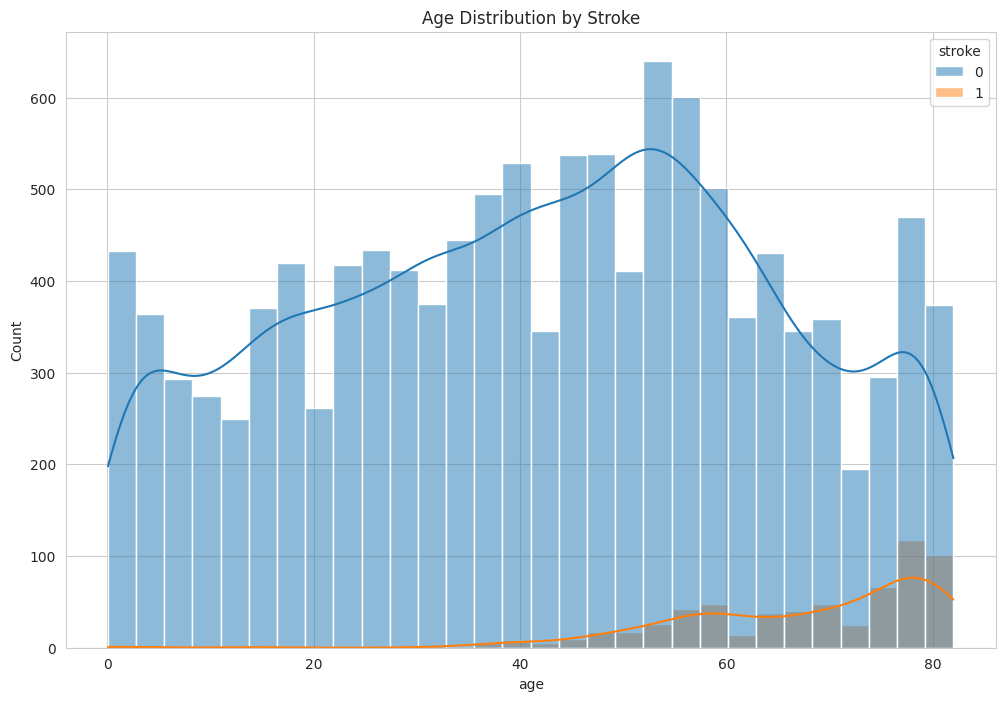

In [232]:
plt.figure(figsize=(12, 8))
sns.histplot(data=df, x='age', hue='stroke', bins=30, kde=True)
plt.title('Age Distribution by Stroke')
plt.savefig('age_distribution.png')
plt.show()

**Group data by different features**

In [235]:
print("Stroke Distribution:")
print(df['stroke'].value_counts())
print(df['stroke'].value_counts(normalize=True) * 100)


Stroke Distribution:
stroke
0    12183
1      633
Name: count, dtype: int64
stroke
0    95.060861
1     4.939139
Name: proportion, dtype: float64


**Group data by key features**

In [234]:
for feature in ['gender', 'age_group', 'hypertension', 'heart_disease']:
    print(f"\nStroke Rate by {feature}:")
    print(df.groupby(feature)['stroke'].mean() * 100)


Stroke Rate by gender:
gender
0    4.775841
1    5.172739
2    0.000000
Name: stroke, dtype: float64

Stroke Rate by age_group:
age_group
0-20       0.195389
21-40      0.490036
41-60      4.187947
61-80     13.141133
81-100    19.191919
Name: stroke, dtype: float64

Stroke Rate by hypertension:
hypertension
0     4.035254
1    13.354787
Name: stroke, dtype: float64

Stroke Rate by heart_disease:
heart_disease
0     4.223725
1    17.435159
Name: stroke, dtype: float64


<ipython-input-234-c231f6f78288>:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby(feature)['stroke'].mean() * 100)


**Correlation matrix**

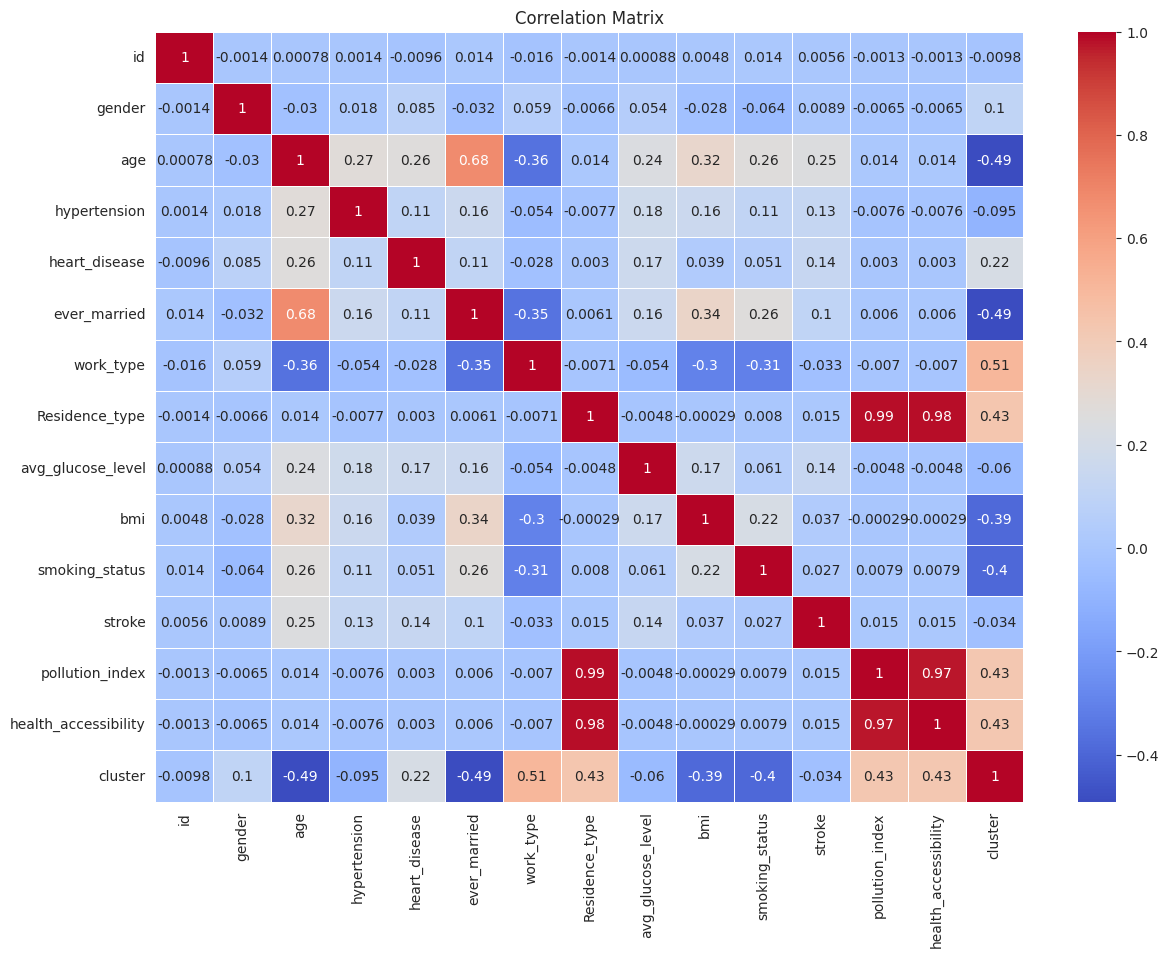

In [258]:
plt.figure(figsize=(14, 10))
numeric_df = df.select_dtypes(include=[np.number])
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.savefig('correlation_matrix.png')
plt.show()

**clustering to identify high-risk groups**

In [259]:
# Perform clustering to identify high-risk groups
def perform_clustering(data, n_clusters=4):
    """Perform clustering to identify high-risk population segments"""
    print("Performing clustering to identify high-risk groups...")

    # Make a copy of data for clustering
    cluster_df = data.copy()

    # Select only numeric columns for clustering
    numeric_cols = cluster_df.select_dtypes(include=[np.number]).columns.tolist()
    # Exclude target variable
    if 'stroke' in numeric_cols:
        numeric_cols.remove('stroke')

    # Scale the data for clustering
    cluster_scaler = StandardScaler()
    scaled_data = cluster_scaler.fit_transform(cluster_df[numeric_cols])

    # Apply K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(scaled_data)

    # Add cluster labels to original dataframe
    data['cluster'] = cluster_labels

    # Analyze each cluster
    print("\nCluster Analysis:")
    for cluster in range(n_clusters):
        cluster_data = data[data['cluster'] == cluster]
        stroke_rate = cluster_data['stroke'].mean() * 100
        print(f"Cluster {cluster}: {len(cluster_data)} patients, Stroke Rate: {stroke_rate:.2f}%")

        # Display average values of key features
        key_features = ['age', 'avg_glucose_level', 'bmi']
        # Add external features if they exist
        for col in ['pollution_index', 'health_accessibility']:
            if col in data.columns:
                key_features.append(col)

        print("Average feature values:")
        for feature in key_features:
            if feature in cluster_data:
                print(f"  {feature}: {cluster_data[feature].mean():.2f}")
        print("-" * 50)

    # Visualize clusters with PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(scaled_data)

    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=cluster_labels, cmap='viridis', alpha=0.5)
    plt.colorbar(scatter, label='Cluster')
    plt.title('Patient Clusters (PCA)')
    plt.xlabel('PCA Feature 1')
    plt.ylabel('PCA Feature 2')
    plt.savefig('clusters_pca.png')
    plt.show()

    # Plot stroke rate by cluster
    plt.figure(figsize=(10, 6))
    cluster_stroke_rates = [data[data['cluster'] == c]['stroke'].mean() * 100 for c in range(n_clusters)]
    plt.bar(range(n_clusters), cluster_stroke_rates)
    plt.xlabel('Cluster')
    plt.ylabel('Stroke Rate (%)')
    plt.title('Stroke Rate by Cluster')
    plt.savefig('stroke_rate_by_cluster.png')
    plt.show()

    return kmeans, cluster_scaler

**Perform clustering**

Performing clustering to identify high-risk groups...

Cluster Analysis:
Cluster 0: 694 patients, Stroke Rate: 17.44%
Average feature values:
  age: 67.95
  avg_glucose_level: 137.55
  bmi: 30.11
  pollution_index: 65.73
  health_accessibility: 0.78
--------------------------------------------------
Cluster 1: 2148 patients, Stroke Rate: 0.37%
Average feature values:
  age: 9.56
  avg_glucose_level: 93.20
  bmi: 20.92
  pollution_index: 67.14
  health_accessibility: 0.79
--------------------------------------------------
Cluster 2: 4061 patients, Stroke Rate: 4.58%
Average feature values:
  age: 47.26
  avg_glucose_level: 106.59
  bmi: 30.32
  pollution_index: 51.00
  health_accessibility: 0.62
--------------------------------------------------
Cluster 3: 5913 patients, Stroke Rate: 5.38%
Average feature values:
  age: 49.92
  avg_glucose_level: 106.77
  bmi: 30.59
  pollution_index: 75.01
  health_accessibility: 0.88
--------------------------------------------------


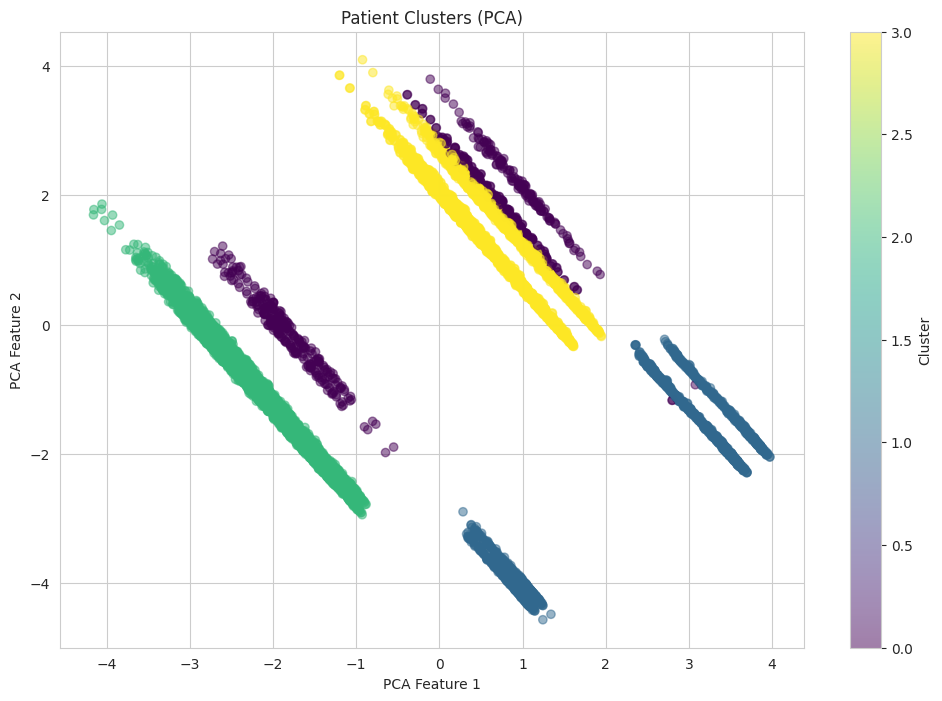

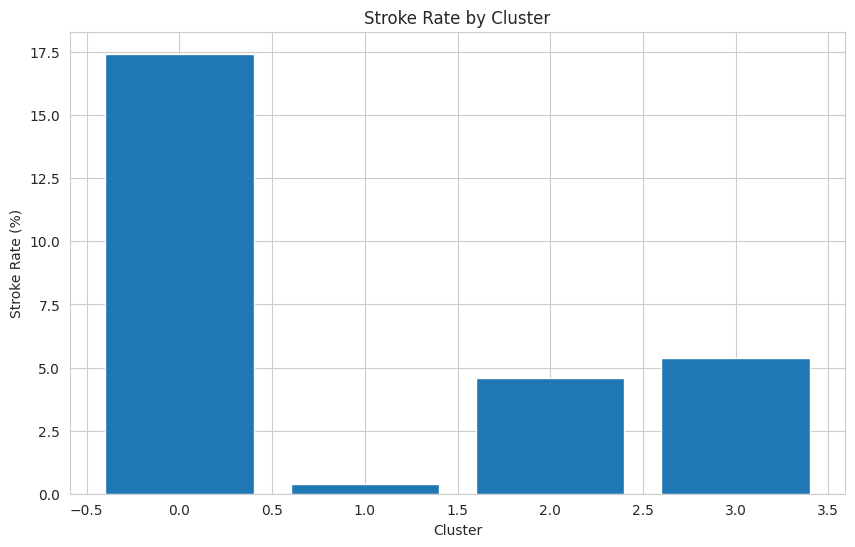

In [260]:
kmeans_model, cluster_scaler = perform_clustering(df)

**Encode categorical variables**

In [261]:
categorical_features = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
label_encoders = {}

for feature in categorical_features:
    le = LabelEncoder()
    df[feature] = le.fit_transform(df[feature])
    label_encoders[feature] = le

**Store external features median values for later use**

In [263]:
external_features = []
external_features_median = {}

# Identify external feature columns
for col in df.columns:
    if 'pollution' in col.lower() or 'health' in col.lower():
        base_col = col.split('_')[0] if '_' in col else col
        if base_col not in external_features:
            external_features.append(base_col)

# Store median values
for feature in external_features:
    for col in df.columns:
        if feature in col.lower():
            external_features_median[feature] = df[col].median()
            break

print(f"External features identified: {external_features}")
print(f"Median values: {external_features_median}")

External features identified: ['pollution', 'health']
Median values: {'pollution': 72.0, 'health': 0.85}


**Drop unnecessary columns before modeling**

In [264]:
if 'id' in df.columns:
    df = df.drop('id', axis=1)
if 'age_group' in df.columns:
    df = df.drop('age_group', axis=1)

**Split features and target**

In [265]:
X = df.drop('stroke', axis=1)
y = df['stroke']

**feature names and count**

In [266]:
print(f"Features for modeling: {X.columns.tolist()}")
print(f"Number of features: {len(X.columns)}")

Features for modeling: ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status', 'pollution_index', 'health_accessibility', 'cluster']
Number of features: 13


**Train-test split**

In [267]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

**Apply SMOTE for class imbalance**

In [269]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

**Feature scaling**

In [270]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)

**Model Building and Evaluation**

In [271]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42),
    'LightGBM': LGBMClassifier(random_state=42)
}

**Train and evaluate each model**

In [272]:
model_scores = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_scaled, y_train_smote)
    y_pred = model.predict(X_test_scaled)

    score = accuracy_score(y_test, y_pred)
    model_scores[name] = score
    print(f"{name} accuracy: {score:.4f}")

    print("Classification Report:")
    print(classification_report(y_test, y_pred))


Training Logistic Regression...
Logistic Regression accuracy: 0.7816
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.79      0.87      2437
           1       0.14      0.66      0.23       127

    accuracy                           0.78      2564
   macro avg       0.56      0.72      0.55      2564
weighted avg       0.94      0.78      0.84      2564


Training Random Forest...
Random Forest accuracy: 0.9509
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      2437
           1       0.51      0.23      0.32       127

    accuracy                           0.95      2564
   macro avg       0.73      0.61      0.64      2564
weighted avg       0.94      0.95      0.94      2564


Training XGBoost...
XGBoost accuracy: 0.9633
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM accuracy: 0.9466
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      2437
           1       0.46      0.40      0.43       127

    accuracy                           0.95      2564
   macro avg       0.71      0.69      0.70      2564
weighted avg       0.94      0.95      0.94      2564



/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


**Plot confusion matrix**

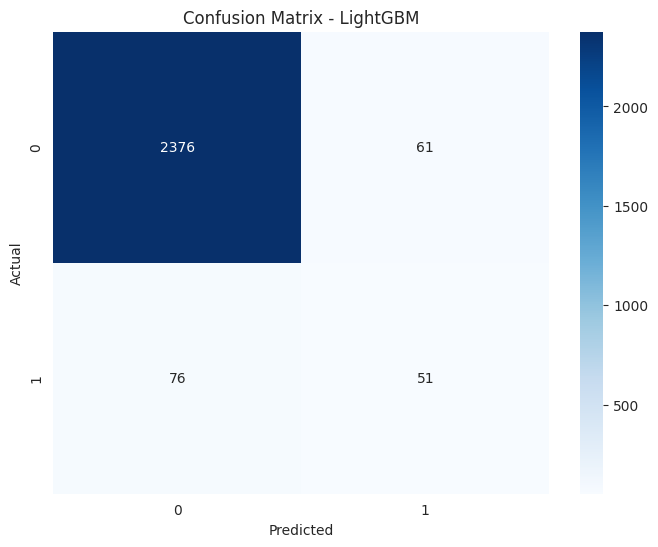

In [285]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix - {name}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig(f'confusion_matrix_{name.replace(" ", "_")}.png')
plt.show()


**Plot ROC curve**

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


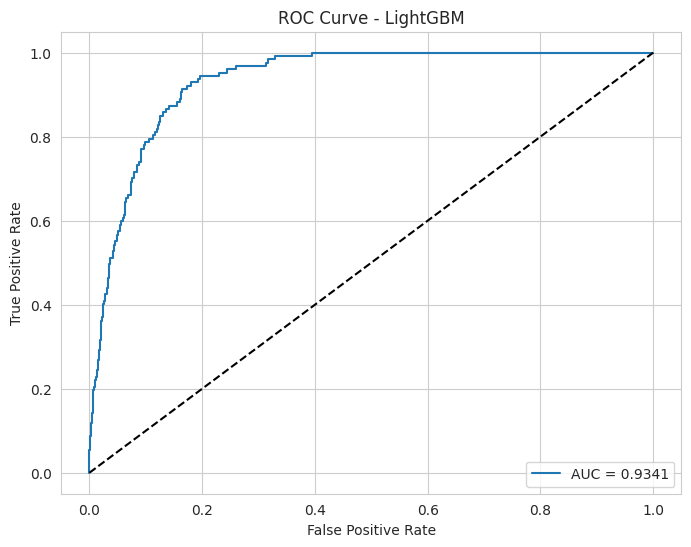

In [278]:
if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {name}')
        plt.legend(loc='lower right')
        plt.savefig(f'roc_curve_{name.replace(" ", "_")}.png')
        plt.show()

**Model Selection and Explanation**

In [286]:
best_model_name = max(model_scores, key=model_scores.get)
best_model = models[best_model_name]
print(f"\nBest model: {best_model_name} with accuracy {model_scores[best_model_name]:.4f}")


Best model: XGBoost with accuracy 0.9633


**SHAP values for model explanation**

In [287]:
n_shap = min(500, len(X_test))
X_shap = X_test[:n_shap]

explainer = shap.Explainer(best_model)
shap_values = explainer(X_test_scaled[:n_shap])

**SHAP summary**

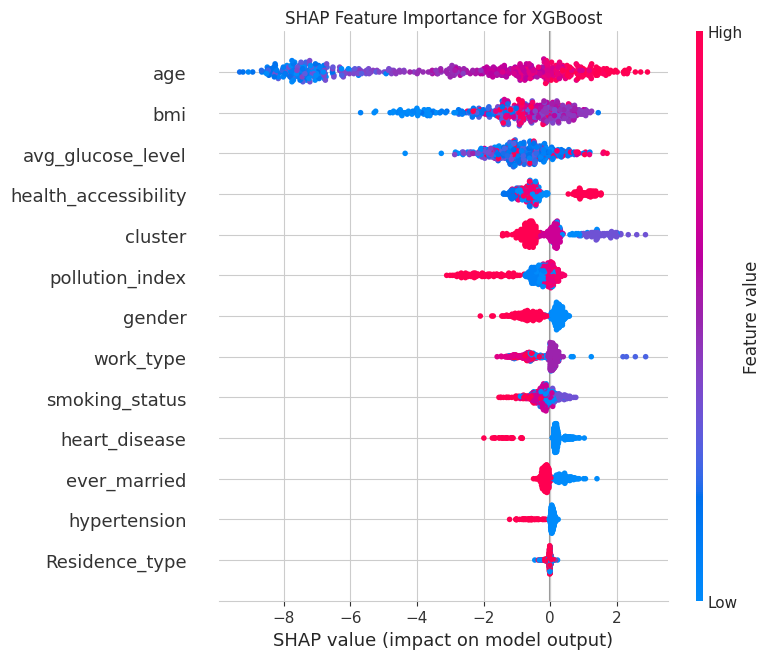

In [288]:
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_shap, feature_names=X.columns, show=False)
plt.title(f'SHAP Feature Importance for {best_model_name}')
plt.tight_layout()
plt.savefig('shap_summary.png')
plt.show()

**Plot SHAP bar plot**

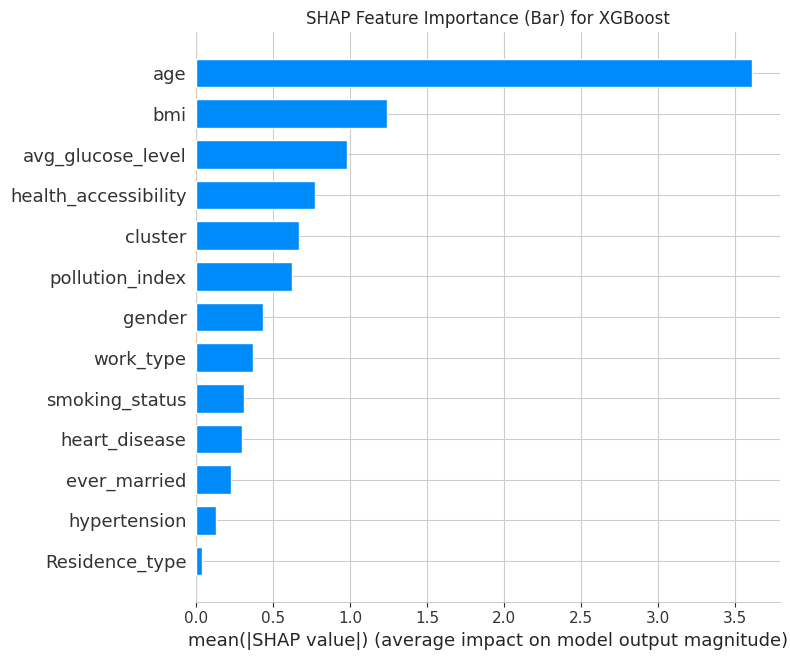

In [289]:
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_shap, feature_names=X.columns, plot_type='bar', show=False)
plt.title(f'SHAP Feature Importance (Bar) for {best_model_name}')
plt.tight_layout()
plt.savefig('shap_bar.png')
plt.show()

**Model Saving**

In [290]:
joblib.dump(best_model, 'stroke_prediction_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(kmeans_model, 'kmeans_model.pkl')
joblib.dump(cluster_scaler, 'cluster_scaler.pkl')
print("Models saved to disk")

Models saved to disk


**explain predictions with LIME**

In [291]:
def explain_with_lime(instance, feature_names):
    """Generate LIME explanation for a single prediction"""
    # Create a LIME explainer
    explainer = lime.lime_tabular.LimeTabularExplainer(
        X_train_scaled,
        feature_names=feature_names,
        class_names=['No Stroke', 'Stroke'],
        discretize_continuous=True,
        mode='classification'
    )

    # Generate explanation
    exp = explainer.explain_instance(
        instance,
        best_model.predict_proba,
        num_features=10
    )

    # Get feature importance as dictionary
    feature_importance = dict(exp.as_list())

    return exp, feature_importance

# Function to generate LIME explanation text
def generate_lime_explanation(input_scaled, input_df, feature_names):
    """Generate LIME explanation text for Gradio interface"""
    try:
        exp, importance = explain_with_lime(input_scaled[0], feature_names)

        # Format explanation as text
        explanation_text = "Feature Contributions to Prediction:\n"
        for feature, value in sorted(importance.items(), key=lambda x: abs(x[1]), reverse=True):
            # Format the value
            if value > 0:
                explanation_text += f"↑ {feature}: +{value:.4f}\n"
            else:
                explanation_text += f"↓ {feature}: {value:.4f}\n"

        return explanation_text
    except Exception as e:
        import traceback
        traceback.print_exc()
        return f"Error generating explanation: {str(e)}"

**Function for individual prediction**

In [293]:
def predict_stroke(gender, age, hypertension, heart_disease, ever_married, work_type,
                  residence_type, avg_glucose_level, bmi, smoking_status):
    try:
        # Load models if not already loaded
        global best_model, scaler
        if 'best_model' not in globals() or best_model is None:
            best_model = joblib.load('stroke_prediction_model.pkl')
            scaler = joblib.load('scaler.pkl')

        print(f"Processing inputs: gender={gender}, age={age}, hypertension={hypertension}, heart_disease={heart_disease}")

        # Convert input values
        gender_val = gender_map[gender]
        hypertension_val = 1 if hypertension else 0
        heart_disease_val = 1 if heart_disease else 0
        married_val = married_map[ever_married]
        work_val = work_map[work_type]
        residence_val = residence_map[residence_type]
        smoking_val = smoking_map[smoking_status]

        # Create a dictionary for input values
        input_dict = {
            'gender': [gender_val],
            'age': [age],
            'hypertension': [hypertension_val],
            'heart_disease': [heart_disease_val],
            'ever_married': [married_val],
            'work_type': [work_val],
            'Residence_type': [residence_val],
            'avg_glucose_level': [avg_glucose_level],
            'bmi': [bmi],
            'smoking_status': [smoking_val]
        }

        # Add external features with default values
        for feature, value in external_features_median.items():
            input_dict[feature] = [value]
            print(f"Added external feature {feature} with value {value}")

        # Create input DataFrame
        input_df = pd.DataFrame(input_dict)

        # Ensure columns match training data exactly
        missing_cols = set(X.columns) - set(input_df.columns)
        for col in missing_cols:
            input_df[col] = 0
            print(f"Added missing column {col} with default value 0")

        input_df = input_df[X.columns]
        print(f"Input shape: {input_df.shape}, expected shape: (1, {len(X.columns)})")

        # Scale the input data
        input_scaled = scaler.transform(input_df)

        # Make prediction
        prediction = best_model.predict(input_scaled)[0]
        probability = best_model.predict_proba(input_scaled)[0][1]

        # Assign to cluster (optional)
        try:
            if 'kmeans_model' in globals() and kmeans_model is not None:
                cluster_data = input_df.copy()
                # Select numeric columns only
                numeric_cols = [c for c in cluster_data.columns if c in X.select_dtypes(include=[np.number]).columns]
                cluster_scaled = cluster_scaler.transform(cluster_data[numeric_cols])
                cluster = kmeans_model.predict(cluster_scaled)[0]
                print(f"Patient assigned to cluster {cluster}")
        except:
            pass

        result = "Stroke Risk: High" if prediction == 1 else "Stroke Risk: Low"
        return result, f"Probability: {probability:.2f}"

    except Exception as e:
        import traceback
        traceback.print_exc()
        print(f"Error in prediction: {str(e)}")
        return f"Error: {str(e)}", "0.00"

**predict with explanation**

In [294]:
def predict_with_explanation(gender, age, hypertension, heart_disease, ever_married, work_type,
                 residence_type, avg_glucose_level, bmi, smoking_status):
    # First get prediction
    result, prob = predict_stroke(gender, age, hypertension, heart_disease, ever_married, work_type,
                 residence_type, avg_glucose_level, bmi, smoking_status)

    # Then generate explanation
    try:
        # Create input dict for explanation
        input_dict = {
            'gender': [gender_map[gender]],
            'age': [age],
            'hypertension': [1 if hypertension else 0],
            'heart_disease': [1 if heart_disease else 0],
            'ever_married': [married_map[ever_married]],
            'work_type': [work_map[work_type]],
            'Residence_type': [residence_map[residence_type]],
            'avg_glucose_level': [avg_glucose_level],
            'bmi': [bmi],
            'smoking_status': [smoking_map[smoking_status]]
        }

        # Add external features
        for feature, value in external_features_median.items():
            input_dict[feature] = [value]

        # Create DataFrame
        input_df = pd.DataFrame(input_dict)

        # Ensure columns match training data exactly
        missing_cols = set(X.columns) - set(input_df.columns)
        for col in missing_cols:
            input_df[col] = 0

        input_df = input_df[X.columns]

        # Scale
        input_scaled = scaler.transform(input_df)

        # Generate explanation text
        explain_text = generate_lime_explanation(input_scaled, input_df, X.columns)

        return result, prob, explain_text
    except Exception as e:
        import traceback
        traceback.print_exc()
        return result, prob, f"Explanation error: {str(e)}"

**Excel Integration**

In [295]:
def import_from_excel(excel_file):
    """Import data from Excel file for batch prediction."""
    try:
        df = pd.read_excel(excel_file)
        print(f"Successfully imported data from Excel, shape: {df.shape}")
        return df
    except Exception as e:
        print(f"Error importing Excel file: {str(e)}")
        return None

def export_to_excel(input_data, predictions, probabilities, output_file="stroke_predictions.xlsx"):
    """Export prediction results to a formatted Excel file."""
    try:
        # Create results DataFrame
        results_df = input_data.copy()
        results_df['Prediction'] = predictions
        results_df['Probability'] = probabilities
        results_df['Risk_Category'] = ['High' if p >= 0.5 else 'Low' for p in probabilities]

        # Export to Excel with formatting
        wb = Workbook()
        ws = wb.active
        ws.title = "Stroke Predictions"

        # Add headers
        ws.append(["Stroke Prediction Results"])
        ws.append(["Generated on", pd.Timestamp.now().strftime("%Y-%m-%d %H:%M:%S")])
        ws.append([])  # Empty row

        # Add data
        for r in dataframe_to_rows(results_df, index=False, header=True):
            ws.append(r)

        # Save file
        wb.save(output_file)
        print(f"Predictions exported to {output_file}")

        # Try to make it downloadable in Colab
        try:
            from google.colab import files
            files.download(output_file)
            print("File is available for download")
        except:
            pass

        return output_file
    except Exception as e:
        print(f"Error exporting to Excel: {str(e)}")
        return None

def batch_predict_from_excel(file_path):
    """Process Excel file and perform batch prediction."""
    # Import data
    data = import_from_excel(file_path)
    if data is None:
        return "Error importing data"

    try:
        # Load model and scaler if not already loaded
        global best_model, scaler
        if 'best_model' not in globals() or best_model is None:
            best_model = joblib.load('stroke_prediction_model.pkl')
            scaler = joblib.load('scaler.pkl')

        # Get required columns (core features)
        core_columns = ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
                       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status']

        # Check if all core columns exist
        missing_cols = [col for col in core_columns if col not in data.columns]
        if missing_cols:
            return f"Missing core columns in Excel file: {missing_cols}"

        # Create a working copy of the data
        processed_data = data.copy()

        # Add external features with default values if they don't exist
        for feature, value in external_features_median.items():
            if feature not in processed_data.columns:
                processed_data[feature] = value
                print(f"Added external feature {feature} with value {value}")

        # Convert categorical columns if needed
        if 'gender' in processed_data.columns and processed_data['gender'].dtype == 'object':
            mappings = [
                ('gender', gender_map),
                ('ever_married', married_map),
                ('work_type', work_map),
                ('Residence_type', residence_map),
                ('smoking_status', smoking_map)
            ]

            for col, mapping in mappings:
                if col in processed_data.columns and processed_data[col].dtype == 'object':
                    processed_data[col] = processed_data[col].map(mapping)
                    # Handle missing mappings
                    if processed_data[col].isna().any():
                        print(f"Warning: Some values in {col} couldn't be mapped. Using mode.")
                        processed_data[col].fillna(processed_data[col].mode()[0], inplace=True)

        # Handle boolean columns
        bool_columns = ['hypertension', 'heart_disease']
        for col in bool_columns:
            if col in processed_data.columns and processed_data[col].dtype == 'bool':
                processed_data[col] = processed_data[col].astype(int)

        # Ensure all required model columns exist
        for col in X.columns:
            if col not in processed_data.columns:
                processed_data[col] = 0
                print(f"Added missing column {col} with default value 0")

        # Ensure columns are in the same order as during training
        processed_data = processed_data[X.columns]

        # Scale the data
        X_scaled = scaler.transform(processed_data)

        # Make predictions
        predictions = best_model.predict(X_scaled)
        probabilities = best_model.predict_proba(X_scaled)[:, 1]

        # Export results
        output_file = "stroke_predictions.xlsx"
        result_file = export_to_excel(data, predictions, probabilities, output_file)

        return f"Predictions completed and saved to {result_file}"

    except Exception as e:
        import traceback
        traceback.print_exc()
        return f"Error in batch prediction: {str(e)}"

# Function to process Excel files for Gradio
def process_excel_file(excel_file):
    if excel_file is None:
        return "Please upload an Excel file"
    try:
        # Save the uploaded file temporarily
        temp_path = "temp_upload.xlsx"
        with open(temp_path, "wb") as f:
            f.write(excel_file.read())

        result = batch_predict_from_excel(temp_path)
        return result
    except Exception as e:
        return f"Error: {str(e)}"

**Create enhanced Gradio interface**

In [307]:
with gr.Blocks(title="Stroke Prediction System") as iface:
    gr.Markdown("# Stroke Prediction System")
    gr.Markdown("### Advanced Stroke Risk Assessment with ML and External Data")

    with gr.Tab("Individual Prediction"):
        with gr.Row():
            with gr.Column():
                gender = gr.Dropdown(["Female", "Male", "Other"], label="Gender")
                age = gr.Slider(0, 100, value=50, label="Age")
                hypertension = gr.Checkbox(label="Hypertension")
                heart_disease = gr.Checkbox(label="Heart Disease")
                ever_married = gr.Dropdown(["No", "Yes"], label="Ever Married")

            with gr.Column():
                work_type = gr.Dropdown(["Children", "Govt_job", "Never_worked", "Private", "Self-employed"], label="Work Type")
                residence_type = gr.Dropdown(["Rural", "Urban"], label="Residence Type")
                avg_glucose_level = gr.Slider(50, 300, value=100, label="Average Glucose Level")
                bmi = gr.Slider(10, 50, value=25, label="BMI")
                smoking_status = gr.Dropdown(["Unknown", "Formerly smoked", "Never smoked", "Smokes"], label="Smoking Status")

        predict_btn = gr.Button("Predict")

        with gr.Row():
            with gr.Column():
                prediction = gr.Textbox(label="Prediction")
                probability = gr.Textbox(label="Probability")

            with gr.Column():
                explanation = gr.Textbox(label="Model Explanation", lines=10)

        predict_btn.click(
            fn=predict_with_explanation,
            inputs=[gender, age, hypertension, heart_disease, ever_married, work_type,
                    residence_type, avg_glucose_level, bmi, smoking_status],
            outputs=[prediction, probability, explanation]
        )

    with gr.Tab("Excel Batch Processing"):
        gr.Markdown("## Upload Excel file for batch prediction")
        gr.Markdown("""
        The Excel file should contain columns with these exact names:
        - gender (Female, Male, Other)
        - age (numeric)
        - hypertension (0 or 1)
        - heart_disease (0 or 1)
        - ever_married (Yes or No)
        - work_type (Children, Govt_job, Never_worked, Private, Self-employed)
        - Residence_type (Rural, Urban)
        - avg_glucose_level (numeric)
        - bmi (numeric)
        - smoking_status (Unknown, Formerly smoked, Never smoked, Smokes)
        """)

        excel_file = gr.File(label="Upload Excel File (.xlsx)")
        process_btn = gr.Button("Process Excel File")
        result_text = gr.Textbox(label="Processing Result")

        process_btn.click(
            fn=process_excel_file,
            inputs=[excel_file],
            outputs=[result_text]
        )

    with gr.Tab("Cluster Analysis"):
        gr.Markdown("## High-Risk Population Clusters")
        gr.Markdown("""
        This tab displays the identified high-risk population clusters from the analysis.
        These clusters represent distinct patient profiles with varying stroke risk levels.
        """)

        # Generate and display cluster information
def display_clusters():
    try:
        if 'cluster' not in df.columns:
            return "Clustering not performed yet. Run clustering analysis first."

        result = "# Cluster Analysis Results\n\n"

        for cluster in range(len(df['cluster'].unique())):
            cluster_data = df[df['cluster'] == cluster]
            stroke_rate = cluster_data['stroke'].mean() * 100
            result += f"## Cluster {cluster}:\n"
            result += f"- Number of patients: {len(cluster_data)}\n"
            result += f"- Stroke Rate: {stroke_rate:.2f}%\n"
            result += "- Profile:\n"

            # Add key metrics
            metrics = ['age', 'bmi', 'avg_glucose_level']
            for feature in external_features:
                for col in df.columns:
                    if feature in col.lower():
                        metrics.append(col)
                        break

            for metric in metrics:
                if metric in cluster_data:
                    result += f"  - Average {metric}: {cluster_data[metric].mean():.2f}\n"

            result += "\n"

        return result
    except Exception as e:
        return f"Error displaying clusters: {str(e)}"

cluster_info = gr.Markdown(display_clusters())

** Launch the interface**

In [308]:
try:
    print("Launching Gradio interface...")
    iface.launch(share=True)
    print("Interface launched successfully!")
except Exception as e:
    import traceback
    traceback.print_exc()
    print(f"Error launching interface: {str(e)}")

Launching Gradio interface...
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://a215f55aa0b08a538f.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Interface launched successfully!
